In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

In [2]:
df = pd.read_csv("data/df_new_feats.csv")

df_new = df.query("`Country of Origin` not in ('Panama', 'Myanmar', 'Kenya', 'Madagascar')")
f'we kept {100*df_new.shape[0]/ df.shape[0]:3.2f}% of the data'

'we kept 97.09% of the data'

Por estratificar o conjunto de teste pelos países, mantemos uma distribuição parecida de alturas e continentes para ambos conjuntos de dados. Logo, podemos trabalhar com três objetivos ao mesmo tempo.

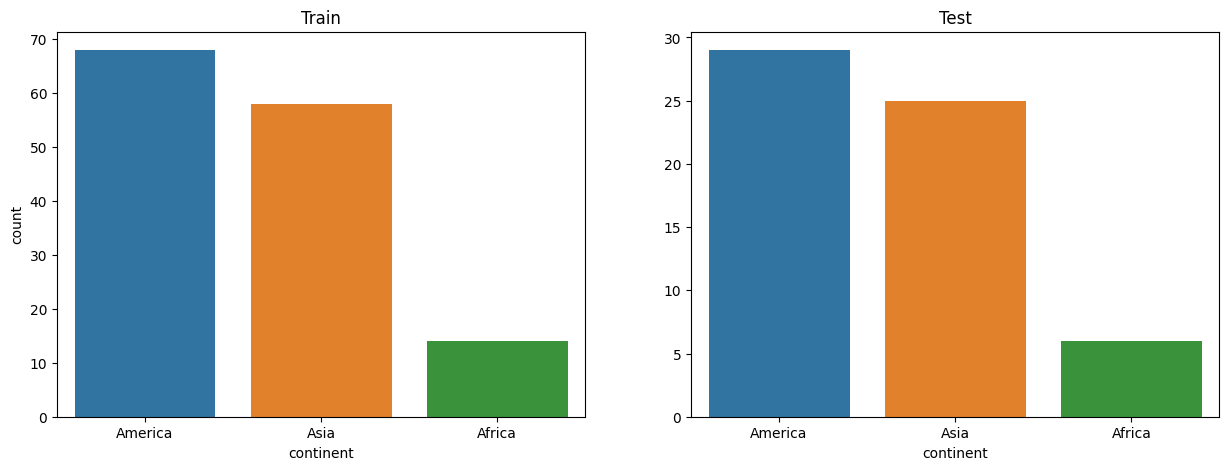

[Text(0.5, 1.0, 'Altitude por divisão do dataset')]

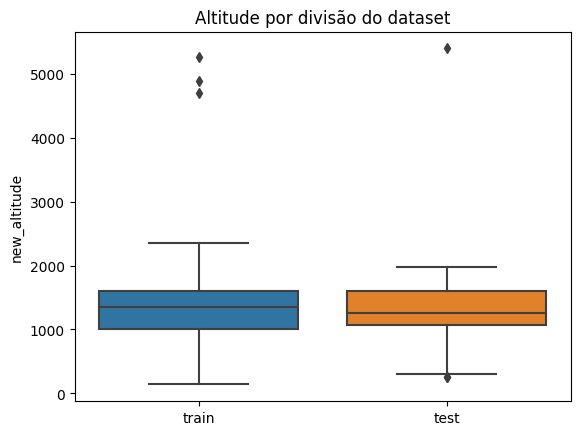

In [13]:
df_x = df_new[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall', 'continent', 'new_altitude']]
df_y = df_new[['Country of Origin']]

X_train_all, X_test_all, y_train_country, y_test_country = train_test_split(df_x, df_y, test_size=0.3, stratify=df_y)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=X_train_all, ax=axes[0] , x="continent", order=["America", "Asia", "Africa"])
axes[0].set_title("Train")
sns.countplot(data=X_test_all, ax=axes[1] , x="continent", order=["America", "Asia", "Africa"])
axes[1].set_title("Test")
axes[1].set(ylabel=None)    
plt.show()


X_train_all['split'] = ['train'] * X_train_all.shape[0]
X_test_all['split'] = ['test'] * X_test_all.shape[0]
s_all = pd.concat([s_train,s_test])
s_all['altitude'] = s_all['new_altitude']
ax = sns.boxplot(s_all,x='split', y='new_altitude')
ax.set(xlabel=None)
ax.set(title="Altitude por divisão do dataset")

In [14]:
## Arrumando as variáveis - o train_test_split nao permite ter um y com mais de uma variável

y_train_continent = X_train_all['continent']
y_train_altitude = X_train_all['new_altitude']

y_test_continent = X_test_all['continent']
y_test_altitude = X_test_all['new_altitude']

X_train = X_train_all[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall']]
X_test = X_test_all[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall']]

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)

print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)